# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь — Изучение поведения клиентов сервиса Яндекс-Книги в Москве и Санкт-Петербурге

- Автор: Хазанов Михаил
- Дата: 30.04.2025

## Цели и задачи проекта

<font color='#777778'>В этом блоке перечислите цель проекта и те задачи, которые вы решаете. Можно использовать описания проекта, но будет полезно, если вы сформулируете основную цель проекта самостоятельно.</font>

Цель проекта - изучить поведение клиентов в сервисе Яндекс-Книги, провести A/B тестирование, сравнить поведение пользователей и увеличить количество покупок от пользователей.

Задачи:
1) Посчитать в SQL метрики - MAU, Retention Rate, LTV, средний чек

2) Интерпретировать метрики и сделать выводы

3) Сравнить пользователей из Санкт-Петербурга и Москвы и посмотреть, как они пользуются сервисами Яндекс-Книги по части чтения и прослушивания.

4) Проверка гипотезы в Python и составление аналитической записки

5) Выводы

## Содержимое проекта

<font color='#777778'>Перечислите основные шаги проекта или напишите оглавление. Используйте описание проекта, чтобы зафиксировать основные шаги.</font>

1) Расчет основных метрик в SQL - MAU, Retention Rate, LTV, средний чек

2) Интерпретация метрик.

3) Сравнение пользователей из Санкт-Петербурга и Москвы и изучение, как они пользуются сервисами Яндекс-Книги по части чтения и прослушивания.

4) Загрузка данных в Python и знакомство с ними.

5) Проверка гипотезы в Python, проведение t-теста

6) Составление аналитической записки

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Пустые ячейки после каждого задания — примерное пространство для работы.
# Вы можете свободно добавлять или удалять ячейки по своему усмотрению в зависимости от логики и объёма работы.

In [2]:
# Используйте ячейки типа Code для вашего кода

In [3]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.power import NormalIndPower
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower
import math


In [4]:
# сохраняем в датафрейм
df = pd.read_csv('/datasets/yandex_knigi_data.csv')
df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [6]:
# Находим количество пользователей по Москве и Санкт-Петербургу
result = df[df['city'].isin(['Москва', 'Санкт-Петербург'])].groupby('city')['puid'].nunique().reset_index()
result.columns = ['city', 'user_count']
print(result)

              city  user_count
0           Москва        6234
1  Санкт-Петербург        2550


In [7]:
# Описательная статистика по времени активности (hours)

description = df.groupby('city')['hours'].describe()
display(description)


,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Москва,6234.0,10.881092,36.851683,0.000018,0.059903,0.924498,5.939972,857.209373
Санкт-Петербург,2550.0,11.592691,39.704993,0.000025,0.080002,0.984781,6.509072,978.764775


In [8]:
# Ищем дубликаты в puid
duplicates = df[df.duplicated(subset='puid')]
display(duplicates)

,Unnamed: 0,city,puid,hours
6247,6247,Санкт-Петербург,2637041,3.883926
6274,6274,Санкт-Петербург,9979490,1.302997
6279,6279,Санкт-Петербург,10597984,9.041320
6283,6283,Санкт-Петербург,10815097,0.323291
6300,6300,Санкт-Петербург,13626259,1.648434
...,...,...,...,...
8771,8771,Санкт-Петербург,1130000018516717,0.517778
8772,8772,Санкт-Петербург,1130000018954257,33.583294
8773,8773,Санкт-Петербург,1130000020425037,2.386944
8775,8775,Санкт-Петербург,1130000023864516,14.384722


In [9]:
# Удаление дубликатов, смотрим количество оставшихся
df = df.drop_duplicates(subset=['puid'])
display(len(df))

8540

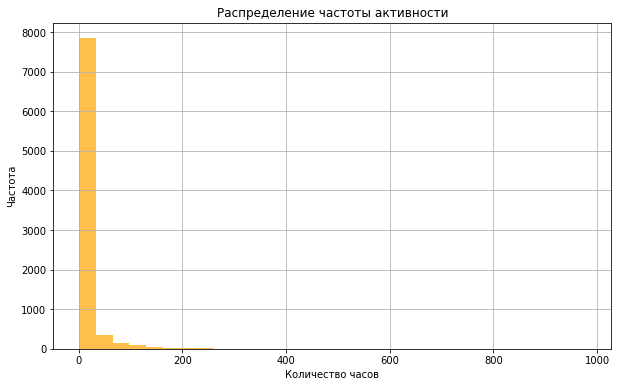

In [10]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(df['hours'], bins=30, color='orange', alpha=0.7)

# Добавление заголовка и подписей осей
plt.title('Распределение частоты активности', fontsize=12)
plt.xlabel('Количество часов', fontsize=10)
plt.ylabel('Частота', fontsize=10)

# Включение сетки для улучшения восприятия
plt.grid()

# Отображение гистограммы
plt.show()


Как видно из графика, абсолютное большинство пользователей активны малое количество часов (примерно до 30 часов), при увеличении количества часов идет резкое падение графика


## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [11]:
# Разделение на две группы
msk_hours = df[df['city'] == 'Москва']['hours']
spb_hours = df[df['city'] == 'Санкт-Петербург']['hours']



In [12]:
# Проводим t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(spb_hours, msk_hours, alternative='greater')

# Вывод результата
print(f"t-статистика: {t_stat}")
print(f"p-value: {p_value}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу и принимаем альтернативную.")
else:
    print("Не удалось отклонить нулевую гипотезу.")

t-статистика: 0.4174122942907679
p-value: 0.338193679651558
Не удалось отклонить нулевую гипотезу.


t-тест был выбран, так как нормальное выборочное среднее (значений больше 30) и значения независимые. Изучали пользователей Москвы и Санкт-Петербурга на предмет пользования сервисом Яндекс-книги по части чтения и прослушивания. Дубликаты отсеяны, пересечений не было.

In [13]:

alpha = 0.05
mw_test = mannwhitneyu(
    spb_hours, # Выборка значений метрики для группы B
    msk_hours, # Выборка значений метрики для группы A
    alternative='greater'
                           
)
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах A и B различаются')

pvalue=0.6189600878052618 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны


<div class="alert alert-info"> <b>Комментарии студента:</b> Добавил над твоим комментарием. Но, честно говоря, распределение не совсем нормальное, скошенное вправо. Сделал дополнительно U-тест, там нулевая гипотеза тоже находит подтверждение. </div>

<div class="alert alert-info"> <b>Комментарии студента №2:</b> Спасибо за совет, чуть ниже немного заморочился) Получается, что дисперсии равны, значит можем использовать t-тест)
    
P.S. U-тест не удалял выше, так как договорились внутри переписки ничего не трогать) Если проект для Гита можно будет использовать, то "причешу" беусловно)</div>

In [14]:
_, p_var = stats.levene(msk_hours, spb_hours)
print(f"p-value (дисперсии): {p_var:.4f}", "Равны" if p_var > 0.05 else "Не равны")

p-value (дисперсии): 0.6679 Равны


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.

Был выбран t-тест для независимых выборок, изучали уровень пользовательской активности между двумя независимыми группами жителей - Москвы и Санкт-Петербурга. t-тест был выбран, так как нормальное выборочное среднее (значений больше 30) и значения независимые и нормально распределенные. Уровень статистической значимости был выбран 0.05, это стандартное значение.

Округленные результаты теста:
t-статистика: 0.417
p-value: 0.338

Значение p-value составляет 0.338, это существенно выше уровня статистической значимости 0.05, таким образом мы не отвергаем нулевую гипотезу. 
Разница между средней пользовательской активностью жителей Москвы и Санкт-Петербурга не является статистически значимой. Значения можно считать похожими между жителями городов.

Как вариант, это можно объяснить тем, что жители двух "столиц" имеют примерно одинаковые предпочтения, используют одни и те же приложения, имеют идентичный доступ к электронным и аудиокнигам. 
В дальнейшем следует провести более детальный анализ, например, по жанрам книг либо во времени активности (будни-выходные, утро-день-вечер).



----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Цель: Провести оценку результатов А/В-тестирования
Задачи:
1) Загрузить данные и оценить их.

2) Проверить из таблицы participants соответствие требованиям технического задания, равномерность распределения пользователей по группам теста, отсутствие пересечений с конкурирующим тестом.

3) Проверить пользовательскую активность из таблицы events.

4) Оценить достаточность выборки для получения статистически значимых результатов A/B-теста. 

5) Рассчитать общее количество посетителей, а также сделавших покупку.

6) Сделать выводы


## 2. Загрузите данные, оцените их целостность.


In [15]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [16]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [17]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [18]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [20]:
# Проверка уникальных значений в ab_test
display(participants['ab_test'].unique())

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

In [21]:
# Количество уникальных значений в group A,B
display(participants['group'].value_counts())

A    8130
B    6395
Name: group, dtype: int64

In [22]:
# Фильтрация по техническому заданию - тест interface_eu_test
test_participants = participants[participants['ab_test'] == 'interface_eu_test']
display(test_participants)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
2,001064FEAAB631A1,A,interface_eu_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
...,...,...,...,...
14519,FFE600EEC4BA7685,B,interface_eu_test,Android
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14523,FFF28D02B1EACBE1,B,interface_eu_test,PC


In [23]:
print("Распределение по группам:", test_participants['group'].value_counts())


Распределение по группам: B    5467
A    5383
Name: group, dtype: int64


In [24]:
# Статистика распределения
group_ratio = test_participants['group'].value_counts(normalize=True)
print(f"\nРаспределение пользователей:\nГруппа A: {group_ratio['A']:.2%}\nГруппа B: {group_ratio['B']:.2%}")


Распределение пользователей:
Группа A: 49.61%
Группа B: 50.39%


В группе А 5383 пользователя, в группе B 5467 пользователей, соотношение процентов 49.61 и 50.39, группы можно считать практически равномерно распределенными.

In [25]:
# Проверка дубликатов
duplicates = participants[participants.duplicated(subset=['user_id', 'group'])]
display(duplicates)

,user_id,group,ab_test,device
26,0082295A41A867B5,A,recommender_system_test,iPhone
42,00E68F103C66C1F7,A,interface_eu_test,PC
117,02313B9E82255F47,A,interface_eu_test,Mac
265,04F2CF340B4F3822,A,interface_eu_test,PC
274,051D59BC38C3B3AA,A,recommender_system_test,Mac
...,...,...,...,...
14425,FE2AF0E94DBD470E,A,recommender_system_test,Android
14455,FE8F9858BBE502D9,B,recommender_system_test,PC
14459,FEA0C585A53E7027,B,recommender_system_test,Android
14466,FEC0BCA6C323872F,A,interface_eu_test,PC


In [26]:
# Удаление дубликатов
participants = participants.drop_duplicates(subset=['user_id', 'group'])
display(participants)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
...,...,...,...,...
14519,FFE600EEC4BA7685,B,interface_eu_test,Android
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14522,FFF28D02B1EACBE1,B,recommender_system_test,PC


In [27]:
# Группировка по user_id и подсчёт уникальных групп
user_group_counts = test_participants.groupby('user_id')['group'].nunique().reset_index()

# Находим пользователей в нескольких группах
over_users = user_group_counts[user_group_counts['group'] > 1]

display(len(over_users))

0

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [28]:
# Проверяем, есть ли пользователи, участвующие в нескольких тестах
user_test_counts = participants.groupby('user_id')['ab_test'].nunique()
overlapping_users = user_test_counts[user_test_counts > 1].index

# Удаление пользователей
participants = participants[~participants['user_id'].isin(overlapping_users)]
print(participants)

print("Число пользователей в тестах:", len(overlapping_users))


                user_id group                  ab_test   device
0      0002CE61FF2C4011     B        interface_eu_test      Mac
3      0010A1C096941592     A  recommender_system_test  Android
4      001E72F50D1C48FA     A        interface_eu_test      Mac
5      002412F1EB3F6E38     B        interface_eu_test      Mac
6      002540BE89C930FB     B        interface_eu_test  Android
...                 ...   ...                      ...      ...
14519  FFE600EEC4BA7685     B        interface_eu_test  Android
14520  FFE7FC140521F5F6     A        interface_eu_test       PC
14521  FFEFC0E55C1CCD4F     A        interface_eu_test       PC
14522  FFF28D02B1EACBE1     B  recommender_system_test       PC
14524  FFF58BC33966EB51     A        interface_eu_test  Android

[13192 rows x 4 columns]
Число пользователей в тестах: 446


In [29]:
# Удаление пересечений с конкурирующий тестом
all_participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
competition_users = all_participants[all_participants['ab_test'] != 'interface_eu_test']['user_id']
participants = participants[~participants['user_id'].isin(competition_users)]

print(participants)

print("Число пользователей в тестах:", len(competition_users))


                user_id group            ab_test   device
0      0002CE61FF2C4011     B  interface_eu_test      Mac
4      001E72F50D1C48FA     A  interface_eu_test      Mac
5      002412F1EB3F6E38     B  interface_eu_test      Mac
6      002540BE89C930FB     B  interface_eu_test  Android
7      0031F1B5E9FBF708     A  interface_eu_test  Android
...                 ...   ...                ...      ...
14518  FFE5B14BD55C1C5C     A  interface_eu_test       PC
14519  FFE600EEC4BA7685     B  interface_eu_test  Android
14520  FFE7FC140521F5F6     A  interface_eu_test       PC
14521  FFEFC0E55C1CCD4F     A  interface_eu_test       PC
14524  FFF58BC33966EB51     A  interface_eu_test  Android

[9963 rows x 4 columns]
Число пользователей в тестах: 3675


In [30]:
# Пользователи из теста interface_eu_test
test_participants = participants[participants['ab_test'] == 'interface_eu_test']['user_id']

# Оставляем только события, связанные с этими пользователями
filtered_events = events[events['user_id'].isin(test_participants)]

# Убираем выбивающиеся события с user id = Global и End of Black Friday
filtered_events = filtered_events[filtered_events['user_id'] != 'GLOBAL']
filtered_events = filtered_events[~filtered_events['event_name'].str.contains('End of Black Friday Ads Campaign')]


# Проверяем первые строки отфильтрованных данных
display(filtered_events.head())

,user_id,event_dt,event_name,details
64672,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0
64946,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8
66585,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32
67873,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48
67930,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0


In [31]:
# смотрим количество событий после фильтрации
display(len(filtered_events))

73815

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [32]:
# Присоединение по регистрации через merge
merged_time = pd.merge(filtered_events, participants[['user_id', 'ab_test', 'group']], on='user_id', how='inner')

# Hазница между датой события и регистрации
merged_time['lifetime'] = (merged_time['event_dt'] - merged_time['event_dt'].dt.normalize()).dt.days

# Фильтруем для событий, произошедших в первые семь дней, делаем строго неравенство
seven_days = merged_time[merged_time['lifetime'] < 7]

display(seven_days.head())


,user_id,event_dt,event_name,details,ab_test,group,lifetime
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,interface_eu_test,A,0
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,interface_eu_test,A,0
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,interface_eu_test,A,0
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,interface_eu_test,A,0
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,interface_eu_test,A,0


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [33]:

conversion_rate = 0.30  # Базовый показатель конверсии
effect_size = 0.03 / conversion_rate  # mde (0.03 / 0.3 = 0.1, это увеличение на 10% относительных или на 3% в абсолюте)
power = 0.80  # Мощность теста (80%)
alpha = 0.05  # Уровень достоверности (95%)

# Расчёт минимального размера выборки для каждой группы
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

# Общий размер выборки (для двух групп)
total_sample_size = math.ceil(sample_size) * 2

# Вывод результата
print(f"Минимальный размер выборки на группу: {math.ceil(sample_size)}")
print(f"Общий минимальный размер выборки: {total_sample_size}")


Минимальный размер выборки на группу: 1571
Общий минимальный размер выборки: 3142


<div class="alert alert-info"> <b>Комментарии студента:</b> Перенес модули вверх. </div>

Минимальный размер выборки составляет 1571 пользователь, соответственно на обе группы - 3142.

рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [34]:
# Группы участников
grouped_events = seven_days.groupby('group')

# Количество пользователей, оформивших покупку
purchase_counts = grouped_events.apply(lambda x: x[x['event_name'] == 'purchase']['user_id'].nunique())

# Общее количество посетителей в каждой группе
visitor_counts = grouped_events['user_id'].nunique()

results = pd.DataFrame({
    'group': visitor_counts.index,
    'total_visitors': visitor_counts.values,
    'purchasers': purchase_counts.values
})

print(results)


  group  total_visitors  purchasers
0     A            4952        1638
1     B            5011        1782


Предварительно видно, что при практически одинаковом общем количестве пользователей (4952 и 5011), количество покупок в группе В с новым дизайном сайта больше на 144 штуки (1782 против 1638)

- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [35]:
# Расчет абсолютной конверсии
results['conversion_rate'] = results['purchasers'] / results['total_visitors']
absolute_diff_pp = results.loc[1, 'conversion_rate'] - results.loc[0, 'conversion_rate']
print(f"Увеличение конверсии: {absolute_diff_pp*100:.2f}%")

Увеличение конверсии: 2.48%


In [36]:
# Расчет относительной конверсии
relative_diff = (absolute_diff_pp / results.loc[0, 'conversion_rate']) * 100
print(f"Относительный рост: {relative_diff:.2f}%")

Относительный рост: 7.51%


<div class="alert alert-info"> <b>Комментарии студента:</b> Добавил над твоим комментарием.</div>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №2__

Правильно

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Гипотезы:

H0: Конверсия в группах А и В одинаковая. p_A = p_B

H1: Конверсия группы В выше, чем в группе А. p_B > p_A


p_A = success_A / n_A

p_B = success_B / n_B

<div class="alert alert-info"> <b>Комментарии студента №2:</b> 
  Поправил текст, добавил в синюю ячейку.
    
Гипотезы:

H0: Конверсия зарегистрированных пользователей в покупателей (группа В) не увеличится на три процентных пункта с упрощением интерфейса по сравнению с группой А. p_A = p_B

H1: конверсия зарегистрированных пользователей в покупателей (группа В) увеличится на три процентных пункта с упрощением интерфейса по сравнению с группой А. p_B > p_A 

p_A = success_A / n_A

p_B = success_B / n_B </div>

In [37]:
# Расчёт конверсии в каждой группе
results['conversion_rate'] = results['purchasers'] / results['total_visitors']

# Размеры выборок
n_A = results.loc[results['group'] == 'A', 'total_visitors'].values[0]
n_B = results.loc[results['group'] == 'B', 'total_visitors'].values[0]

# Число успехов (покупок)
success_A = results.loc[results['group'] == 'A', 'purchasers'].values[0]
success_B = results.loc[results['group'] == 'B', 'purchasers'].values[0]

print(results)



  group  total_visitors  purchasers  conversion_rate
0     A            4952        1638         0.330775
1     B            5011        1782         0.355618


In [38]:
absolute_diff = results.loc[1, 'conversion_rate'] - results.loc[0, 'conversion_rate']
print(f"Абсолютное увеличение конверсии: {absolute_diff:.4f} ({absolute_diff*100:.2f}%)")

relative_diff = absolute_diff / results.loc[0, 'conversion_rate']
print(f"Относительное увеличение конверсии: {relative_diff:.2%}")

Абсолютное увеличение конверсии: 0.0248 (2.48%)
Относительное увеличение конверсии: 7.51%


Абсолютное увеличение в группе И составило 2.48%, при этом относительное увеличение составило 7.5%. Перед Z-тестом видим, что группа В с обновленным сайтом и пользовательским поведением показывает прирост.

In [39]:


# Данные для теста
counts = [success_A, success_B]  # Число успехов
nobs = [n_A, n_B]  # Размеры выборок

# Односторонний Z-тест
stat, p_value = proportions_ztest(counts, nobs, alternative='smaller')

# Вывод результатов
print(f"Z-статистика: {stat:}")
print(f"P-value: {p_value:}")

Z-статистика: -2.611175555675904
P-value: 0.004511578024761222


<div class="alert alert-info"> <b>Комментарии студента №2:</b> 
Извини за мое глупое ночное рассуждение и "духоту") Боюсь, что "порассуждаю" сейчас, что и в 6 итераций не уложусь) Если можно - не учитывай пжл эту итерацию при кривых расчетах) Скрины вставлять не умею сюда( Если что - поменяю без проблем!
    
В теории 11 модуля (тема 5/11, урок 4/4) по Z-тесту написано: ставим 'smaller', если p_A < p_B, а 'larger' при p_A > p_B 

Я указал 'smaller' # так как H_1: p_a < p_b. 
Но если я тут укажу 'larger', то у меня получится p_value 0.9955 (1 - 0.0045)

Ниже копипаст задачи практикума из модуля 11 по Z-тесту,.


    n_a, n_b = 5818, 5650 # берём предыдущие значения по размерам выборок A и B 
    
    m_a, m_b = 405, 580 # берём предыдущие значения по количеству успехов в выборках A и B 

    alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

    stat_ztest, p_value_ztest = proportions_ztest( [m_a, m_b], [n_a, n_b], alternative='smaller' # так как H_1: p_a < p_b
    )
    p_value_ztest
    # 1.3630147762819648e-10

    if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
              
</div>

In [40]:
# Данные для теста
counts = [success_A, success_B]  # Число успехов
nobs = [n_A, n_B]  # Размеры выборок

# Односторонний Z-тест
stat, p_value = proportions_ztest(counts, nobs, alternative='larger')

# Вывод результатов
print(f"Z-статистика: {stat:}")
print(f"P-value: {p_value:}")

Z-статистика: -2.611175555675904
P-value: 0.9954884219752388


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

Первоначально провели распределение пользователей, группы оказались практически равные с разницей 0.78% (50.39% и 49.61%).
Были выбраны пользователи из теста interface_eu_test. Определили минимальную выборку для проведения теста, общее количество пользователей и количество покупок.
По результатам А/В теста видно, что конверсия увеличилась на 2.48% (35.56% против 33.08%) в абсолюте и на 7.51% в относительном выражении.
Значение p-value (0.0045) меньше уровня статистической значимости (0.05), значит отвергаем нулевую гипотезу и принимаем альтернативную, рекомендуя изменения по новой версии сайта. Конверсия увеличена, тест показал улучшение, которое рекомендуется использовать в дальнейшем. 
Также рекомендуется продолжить наблюдения за изменениями, чтобы конверсия сохранялась и показывала улучшения.
Для улучшения результатов можно провести аналогичные тесты, изучив время нахождения клиентов в сервисе, популярность в разные дни недели и в разное время суток. Также изучить средний чек для его дальнейшего увеличения.

Первоначально базовая конверсия была 0.3 (30%). Мы планировали ее увеличить на 10% в относительном выражении и на 3% в абсолютном. В итоге увеличение составило 7.51% в относительном выражении и на 2.48% в абсолютном. Первоначальной цели мы не достигли, однако увеличение есть и оно статистически значимо. Как вариант, в новой версии сайта можно обратить внимание на кликабельность кнопок и дизайн, чтобы в дальнейшем еще более увеличить конверсию. Потом запустить новый тест с доработанной версией интерфейса.

<div class="alert alert-info"> <b>Комментарии студента №2:</b> копирую в синюю ячейку)
    
Первоначально базовая конверсия была 0.3 (30%). Мы планировали ее увеличить на 10% в относительном выражении и на 3% в абсолютном. В итоге увеличение составило 7.51% в относительном выражении и на 2.48% в абсолютном. Первоначальной цели мы не достигли, однако увеличение есть и оно статистически значимо. Как вариант, в новой версии сайта можно обратить внимание на кликабельность кнопок и дизайн, чтобы в дальнейшем еще более увеличить конверсию. Потом запустить новый тест с доработанной версией интерфейса.
</div>